### 1. Introduction

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this notebook, I will apply my machine learning skills to predict credit default. Specifically, I will leverage the Kaggle's "American Express - Default Prediction" Competition dataset to build a machine learning model. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information.

The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']







My purpose in this notebook is to separate and understand the effect of the numerical features. So I will filter out the categorical features from the training dataset.

I will compare the training times and prediction performances of the following models:
HistGradientBoostingRegressor, Light Gradient Boost Classifer and XGBoost Classifer

### 2. Key Findings


- Feature Selection: I assumed the most highly correlated features with the target are the most important. I experimented with including varying numbers of the most important features in the model and evaluated balanced_accuracy for the various cases. I concluded that including all features in the model leads to the best result.

- I trained three models: HistGradientBoostingRegressor, Light Gradient Boost Classifer and XGBoost Classifer. Light Gradient Boost Classifer gave the best results in terms of balanced accuracy.

- Including categorical features does not seem to make a big difference in the result.

- I evaluated the competition metric using my best model and got a score of 0.78.

### 3. Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import gc
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 4. Load Train Data

The dataset of this competition has a considerable size. If I read the original csv files, the data barely fits into memory. That's why I read the data from @munumbutt's AMEX-Feather-Dataset. In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit. And reading a Feather file is faster than reading a csv file because the Feather file format is binary.

In [2]:
train_data = pd.read_feather('../input/amexfeather/train_data.ftr')

# Most customers have 13 statements and others have 1 to 12 statements. I will look at the most recent statement to make things simpler.
train_data = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')

print("The training data begins on {} and ends on {}.".format(train_data['S_2'].min().strftime('%m-%d-%Y'),train_data['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the training set and {} features.".format(train_data.shape[0],train_data.shape[1]))

The training data begins on 03-01-2018 and ends on 03-31-2018.
There are 458,913 customers in the training set and 190 features.


In [3]:
X_all_features = train_data.iloc[:,1:-1]

categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train_data = train_data.drop(columns=categorical_columns)

X = train_data.iloc[:,1:-1]
y = train_data['target']

n_categorical_features = len(X.select_dtypes(include="category").columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 458913
Number of features: 177
Number of categorical features: 0
Number of numerical features: 177


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 179 entries, S_2 to target
dtypes: datetime64[ns](1), float16(177), int64(1)
memory usage: 165.4+ MB


### 5. Model Training and Evaluation


I will select the most important features and experiment with the number of features included in the models. I will train and evaluate each model based on balanced_accuracy.

Balanced accuracy is a metric used to evaluate the performance of a classification model, especially when the classes are imbalanced. It is the arithmetic mean of the sensitivity (true positive rate) and specificity (true negative rate), calculated for each class. The balanced accuracy gives an unbiased estimate of the model's ability to correctly classify both the majority and minority classes.

Balanced accuracy provides a more reliable evaluation metric than accuracy when dealing with imbalanced datasets, where the class distribution is skewed. This is the case here, because in this dataset, 26% of customers have defaulted. By considering both sensitivity and specificity, it offers a comprehensive assessment of a classifier's performance on both the positive and negative classes. A value of 1 indicates perfect performance, while a value of 0 indicates the worst possible performance.

I will first sort the features based on their correlation with the target. I will assume the higher the crrelation, the more important the feature is. I will train the models with various number of features, top 10 features correlated with the target, top 30, top 50, top 100 and all features. Then I will compare the balanced accuracy score using cross-validation.


In [4]:
targ = train_data.iloc[:,1:-1].corrwith(train_data['target'], axis=0)
sorted_targ = abs(targ).sort_values(ascending=False)

### 5.1. HistGradientBoostingClassifier

I will use the Histogram-based Gradient Boosting Classifier. HistGradientBoostingClassifier is a type of gradient boosting algorithm introduced in scikit-learn, a popular machine learning library in Python. It is an implementation of histogram-based gradient boosting, which is an optimized version of the traditional gradient boosting algorithm. This classifier is efficient for both binary and multiclass classification tasks. This is a faster variant of GradientBoostingClassifier for big datasets.


I will use ordinal encoding to encode categorical features and see if including them in the training data improves balanced_accuracy.

In [5]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
     make_column_selector(dtype_include="category"),),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [7]:
n_cv_folds = 3
scoring = "balanced_accuracy"

model = HistGradientBoostingClassifier(random_state=42)

HGB_top_ten_features = cross_validate(model, X[sorted_targ[:10].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
HGB_top_thirty_features = cross_validate(model, X[sorted_targ[:30].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
HGB_top_fifty_features = cross_validate(model, X[sorted_targ[:50].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
HGB_top_hundred_features = cross_validate(model, X[sorted_targ[:100].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
HGB_numerical_features_only = cross_validate(model, X, y, cv=n_cv_folds, scoring=scoring)

hist_ordinal = make_pipeline(ordinal_encoder, model)
HGB_with_categoricals = cross_validate(hist_ordinal, X_all_features, y, cv=n_cv_folds, scoring=scoring)

In [20]:
def plot_results(figure_title, test_score_y_limit, items, labels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Balanced Accuracy", ax2, test_score_y_limit),
    ]

    n = len(items)
    x, width = np.arange(n), 0.9
    for key, title, ax, y_limit in plot_info:

        mape_cv_mean = [np.mean(np.abs(item[key])) for item in items]
        mape_cv_std = [np.std(item[key]) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=[f"C{i}" for i in range(n)],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=labels,
            ylim=y_limit,
        )
    fig.suptitle(figure_title)

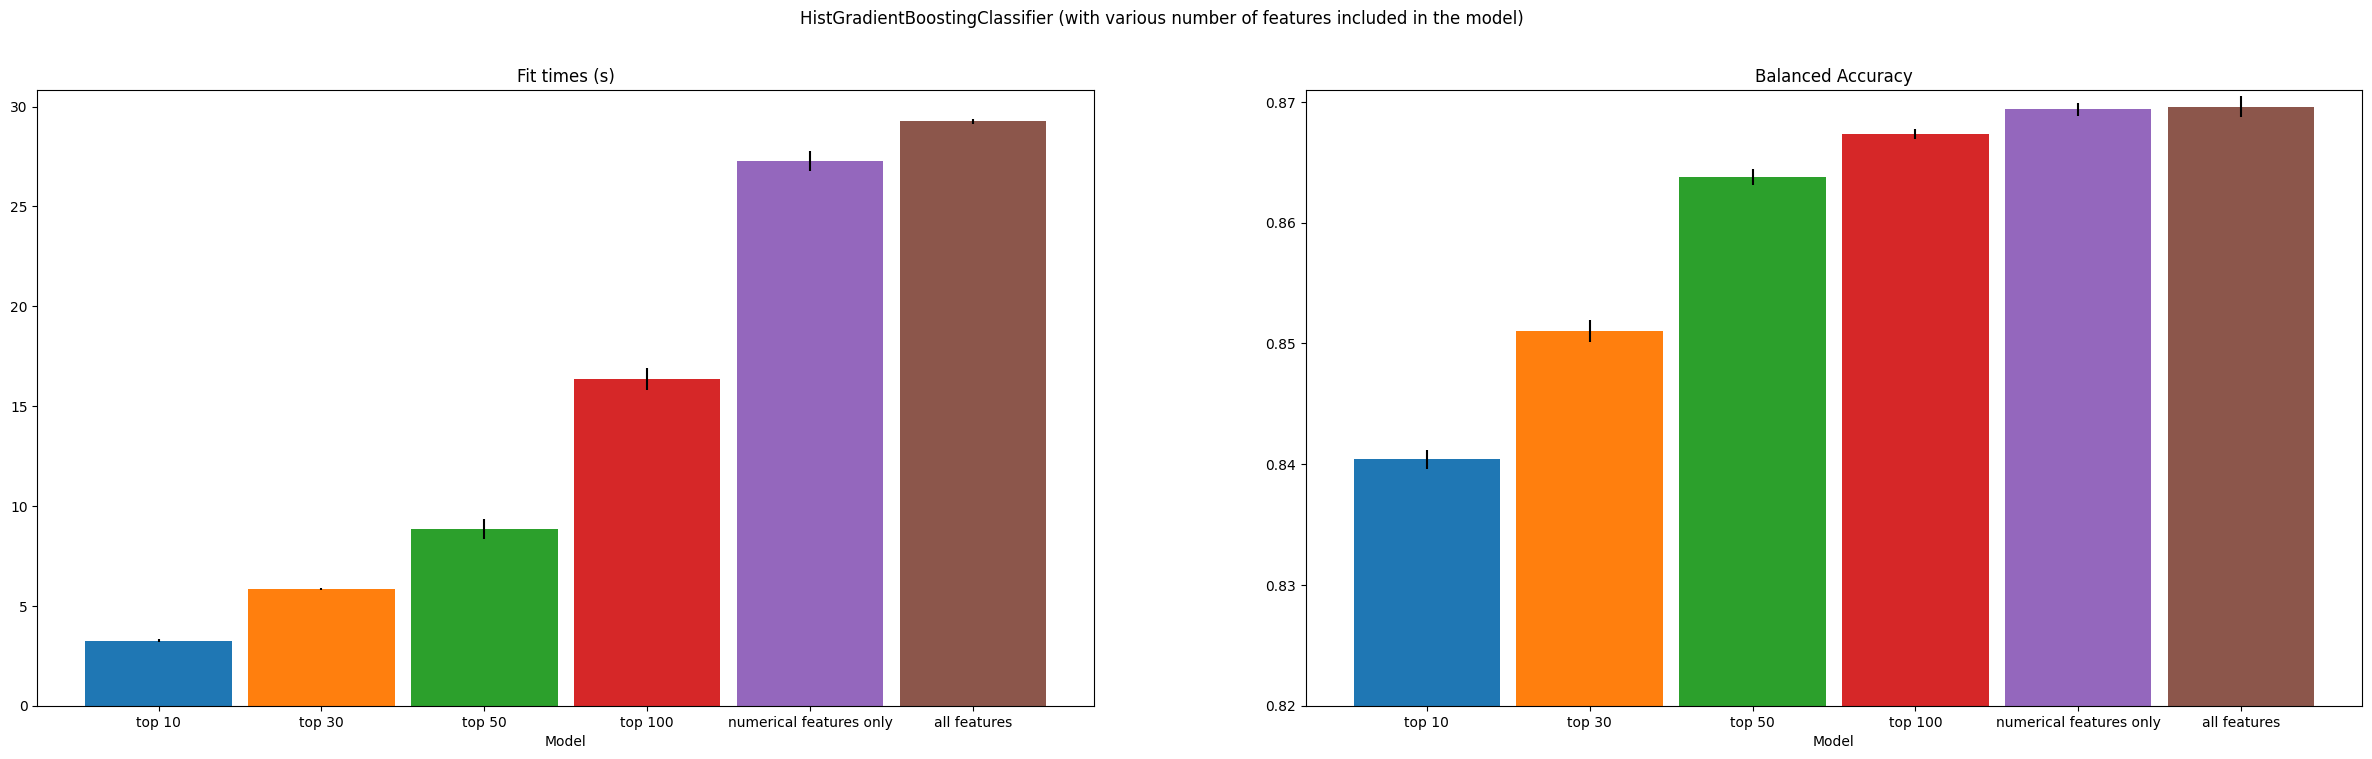

In [9]:
plot_results("HistGradientBoostingClassifier (with various number of features included in the model)", [0.82, 0.871], [HGB_top_ten_features, HGB_top_thirty_features, HGB_top_fifty_features, HGB_top_hundred_features, HGB_numerical_features_only, HGB_with_categoricals], ['top 10', 'top 30', 'top 50', 'top 100', 'numerical features only', 'all features'])

In [10]:
np.mean(HGB_numerical_features_only['test_score'])

0.8693793012392442

In [11]:
print(f"HistGradientBoostingClassifier (trained with numerical features) mean test score: {np.mean(HGB_numerical_features_only['test_score'])}")
print(f"HistGradientBoostingClassifier (trained with all features) mean test score: {np.mean(HGB_with_categoricals['test_score'])}\n")

print(f"HistGradientBoostingClassifier (trained with numerical features) std of test scores: {np.std(HGB_numerical_features_only['test_score'])}")
print(f"HistGradientBoostingClassifier (trained with all features) std of test scores: {np.std(HGB_with_categoricals['test_score'])}")

HistGradientBoostingClassifier (trained with numerical features) mean test score: 0.8693793012392442
HistGradientBoostingClassifier (trained with all features) mean test score: 0.8695972442790922

HistGradientBoostingClassifier (trained with numerical features) std of test scores: 0.0005321489827584189
HistGradientBoostingClassifier (trained with all features) std of test scores: 0.0008727696056869605


### Evaluation with the Competition Metric

The evaluation metric, M, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, G, and default rate captured at 4%,D.
        
        M = 0.5 * (G + D)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics G and D, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.


In [9]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename('prediction')
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

I will use StratifiedKFold with 3 splits to evaluate the competition metric for the HistGradientBoostingClassifier with the numerical features.

In [13]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

y_valid, M=[],[]
model = HistGradientBoostingClassifier()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]

    y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score=amex_metric(y_true = y_true, y_pred = y_pred)
    
    M.append(M_score)
    y_valid.append(y_val)

M

[0.7766771989541674, 0.78014430471214, 0.7829448098794668]

In [14]:
print(f"Competition metric score for the numerical features using HistGradientBoostingClassifier: {np.mean(M)}")

Competition metric score for the numerical features using HistGradientBoostingClassifier: 0.7799221045152581


### Insights:

- The model with the largest number of features is by far the slowest, which is expected. It also has the highest balanced_accuracy.


- The balanced_accuracy score is very close for the model trained with only the numerical features and the model trained with all features (numerical and categorical).

- The competition metric score for numerical features is 0.78. This is a much better result than the categorical features result (Evaluated at the Categorical Features notebook).

### 5.2 LightGBM Classifier

LightGBM, short for light gradient-boosting machine, is a free and open-source distributed gradient-boosting framework for machine learning, originally developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks. LightGBM (Light Gradient Boosting Machine) is a powerful and efficient gradient boosting framework developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks. It is designed for distributed and efficient training of large-scale datasets. LightGBM is known for its speed, scalability, and high performance.

I will use RandomizedSearchCV to find the optimal hyperparamters for lightGBM. I will train LGBM with ordinal encoded and one-hot encoded categorical features and will compare performance and fit for this model.

In addition, since the target variable is slightly imbalanced, I will use Stratified K-Fold cross-validation to maintain the class distribution in each training and validation set.

### Hyperparameter Tuning

I will use RandomizedSearchCV for finding the best hyperparameters for LGBGM model using random search. RandomizedSearchCV is a faster alternative to GridSearchCV, which performs an exhaustive search over a specified grid of hyperparameters. Unlike GridSearchCV, which tries every possible combination of hyperparameters, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified distributions. This approach is useful when the search space of hyperparameters is large and it is computationally expensive to explore every single combination.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(boosting_type='gbdt',random_state=42)

param_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}
search_random = RandomizedSearchCV(model, param_distributions = param_random_gb, n_iter = 10, scoring = 'balanced_accuracy', cv = 4, verbose = 1)
search_random.fit(X_train, y_train)

print("Best parameter: ", search_random.best_params_)

The resulst of the random search:

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameter:  {'subsample': 0.5, 'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.15000000000000002}

### ROC Curve and AUC Metric

Here I will use StratifiedKFold with 10 splits to train the LGBM model and evaluate the competition metric and AUC for each fold.

AUC, or Area Under the Curve, is a metric commonly used to evaluate the performance of a classification model, particularly in binary classification tasks. It represents the area under the receiver operating characteristic (ROC) curve, which is a graphical representation of the true positive rate (sensitivity) plotted against the false positive rate (1 - specificity) at various thresholds. AUC is a popular metric for evaluating the overall performance of a classification model, especially when the class distribution is imbalanced like our dataset. It provides a single value that summarizes the model's ability to discriminate between the classes across all possible classification thresholds.

AUC ranges from 0 to 1, where a model with perfect discrimination has an AUC value of 1, while a model with no discrimination or a completely random classifier has an AUC of 0.5. The higher the AUC value, the better the model's ability to distinguish between the positive and negative classes.

In [15]:
gbm_val_probs, M, y_valid = [], [], []
ft_importance=pd.DataFrame(index=X.columns)

# Create and train the LGBMClassifier
model = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=175, learning_rate=0.15, max_depth=4,random_state=42, subsample=0.5)

sk_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):
        
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                                           callbacks=[early_stopping(200), log_evaluation(500)],
                                           eval_metric=['auc','binary_logloss'])
    y_valid.append(y_val)

    y_pred=model.predict_proba(X_val)[:,1]
    gbm_val_probs.append(y_pred)

    y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score = amex_metric(y_true = y_true, y_pred = y_pred)
    M.append(M_score)
    
    auc_score=roc_auc_score(y_val, y_pred)
    ft_importance["Importance_Fold"+str(fold)]=model.feature_importances_    
    print("Validation Metric: {:.5f}, AUC: {:.4f}".format(M_score,auc_score))
    
    del X_train, y_train, X_val, y_val
    _ = gc.collect()


Fold 1
Train shape: (305942, 177), (305942,), Valid shape: (152971, 177), (152971,)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[175]	training's auc: 0.963996	training's binary_logloss: 0.211245	valid_1's auc: 0.958306	valid_1's binary_logloss: 0.226096
Validation Metric: 0.77861, AUC: 0.9583

Fold 2
Train shape: (305942, 177), (305942,), Valid shape: (152971, 177), (152971,)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[175]	training's auc: 0.96394	training's binary_logloss: 0.211303	valid_1's auc: 0.958477	valid_1's binary_logloss: 0.225768
Validation Metric: 0.78089, AUC: 0.9585

Fold 3
Train shape: (305942, 177), (305942,), Valid shape: (152971, 177), (152971,)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[175]	training's auc: 0.96358	training's binary_logloss: 0.212211	valid_1's auc: 

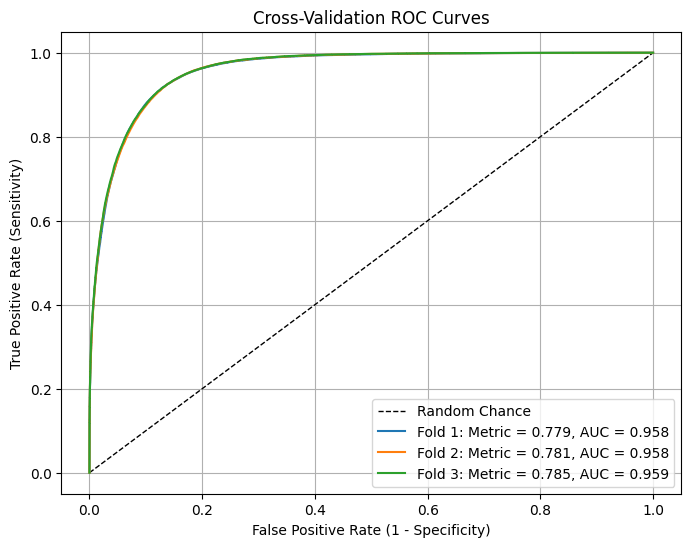

In [16]:
def plot_roc(y_val, y_prob, M):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1, label='Random Chance')

    for i in range(len(y_val)):
        y = y_val[i]
        prob = y_prob[i]
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Fold {}: Metric = {:.3f}, AUC = {:.3f}'.format(i + 1, M[i], roc_auc))

    plt.title("Cross-Validation ROC Curves")
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc(y_valid, gbm_val_probs, M)

The model has an AUC of 0.96, which is pretty good.

Next I will explore with feature selection.

### Feature Selection and Balanced Accuracy

I will experiment with including the top most correlated features in the model and cross_validating with balanced_accuracy score. This will show if limitting features to the highest correlated with the target improves performance and/or fit time. 

In [18]:
n_cv_folds = 3
scoring = "balanced_accuracy"

model = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=175, learning_rate=0.15, max_depth=4,random_state=42, subsample=0.5)

LGB_top_ten_features = cross_validate(model, X[sorted_targ[:10].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
LGB_top_thirty_features = cross_validate(model, X[sorted_targ[:30].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
LGB_top_fifty_features = cross_validate(model, X[sorted_targ[:50].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
LGB_top_hundred_features = cross_validate(model, X[sorted_targ[:100].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
LGB_numerical_features_only = cross_validate(model, X, y, cv=n_cv_folds, scoring=scoring)

lgbm_ordinal = make_pipeline(ordinal_encoder, model)
LGB_with_categoricals = cross_validate(lgbm_ordinal, X_all_features, y, cv=n_cv_folds, scoring=scoring)

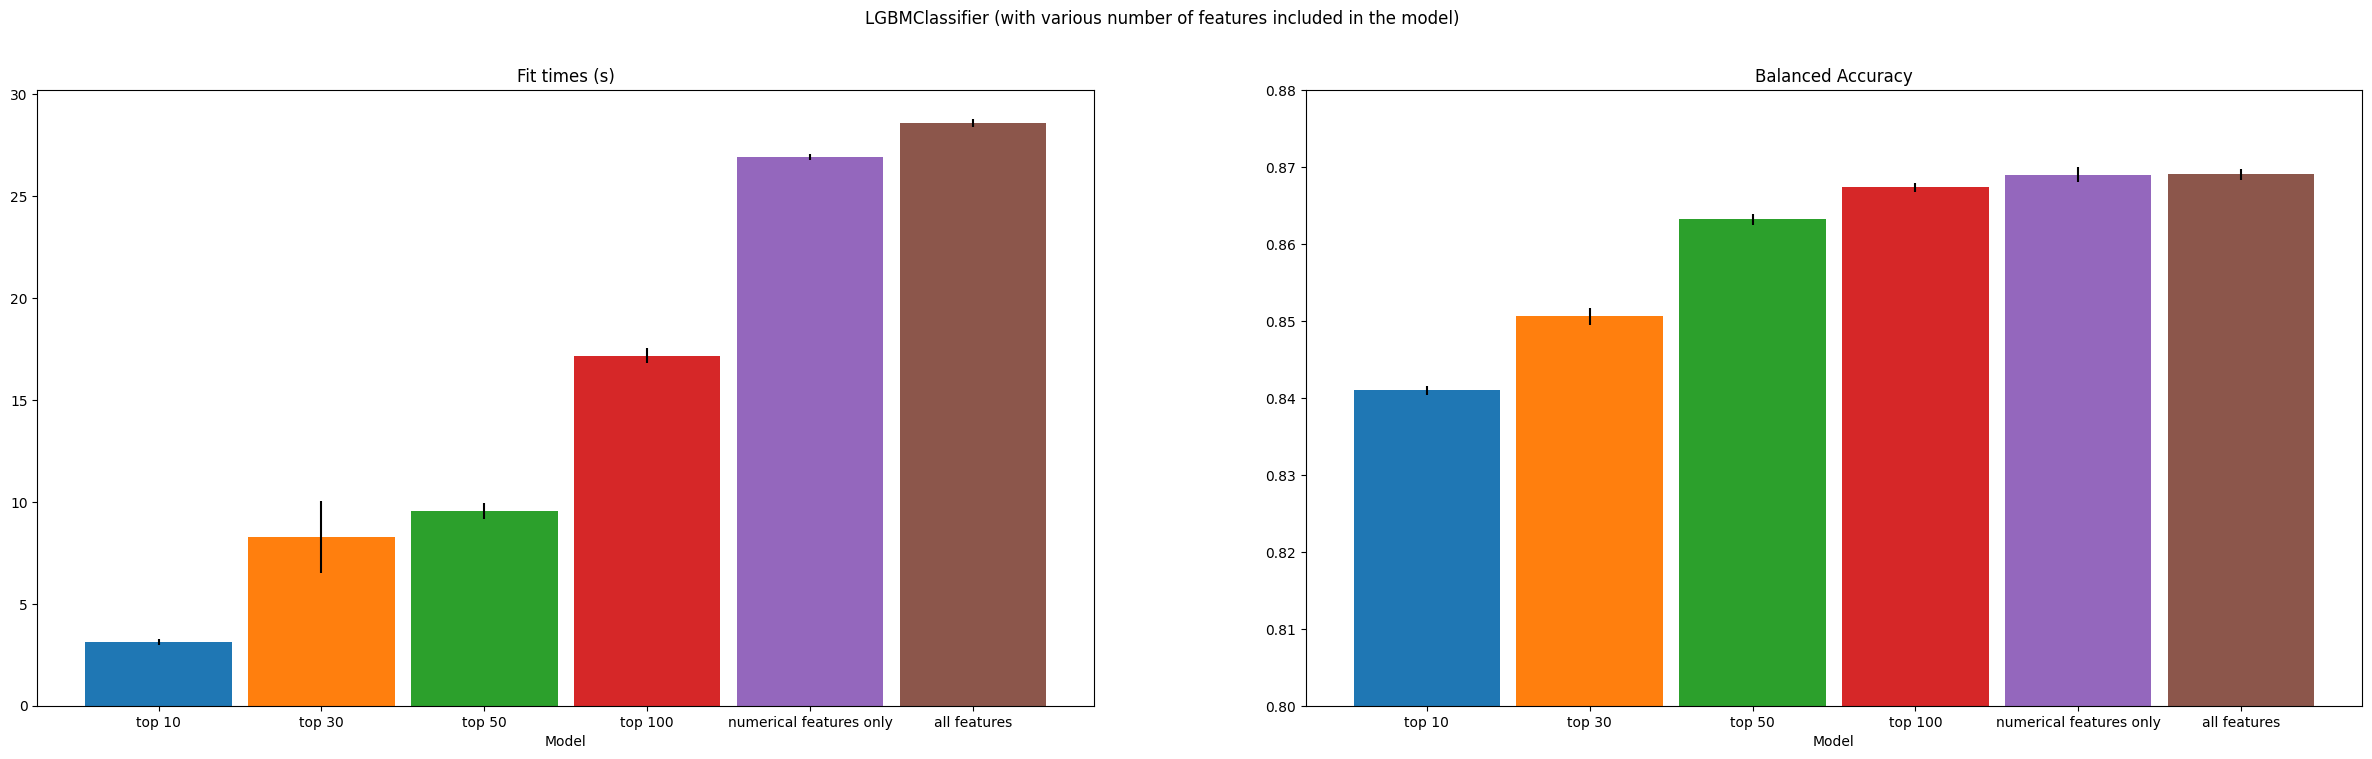

In [19]:
plot_results("LGBMClassifier (with various number of features included in the model)", [0.8, 0.88], [LGB_top_ten_features, LGB_top_thirty_features, LGB_top_fifty_features, LGB_top_hundred_features, LGB_numerical_features_only, LGB_with_categoricals], ['top 10', 'top 30', 'top 50', 'top 100', 'numerical features only', 'all features'])

In [20]:
print(f"LGBMClassifier (trained with numerical features) mean test score: {np.mean(LGB_numerical_features_only['test_score'])}")
print(f"LGBMClassifier (trained with all features) mean test score: {np.mean(LGB_with_categoricals['test_score'])}\n")

print(f"LGBMClassifier (trained with numerical features) std of test scores: {np.std(LGB_numerical_features_only['test_score'])}")
print(f"LGBMClassifier (trained with all features) std of test scores: {np.std(LGB_with_categoricals['test_score'])}")

LGBMClassifier (trained with numerical features) mean test score: 0.8689811071946932
LGBMClassifier (trained with all features) mean test score: 0.869013353887202

LGBMClassifier (trained with numerical features) std of test scores: 0.0009834104343680254
LGBMClassifier (trained with all features) std of test scores: 0.0007422750800860471


In [21]:
ft_importance['avg']=ft_importance.mean(axis=1)
ft_importance=ft_importance.avg.nlargest(50).sort_values(ascending=True)

Text(0.5, 1.0, 'LGBM Feature Importance (Top 50)')

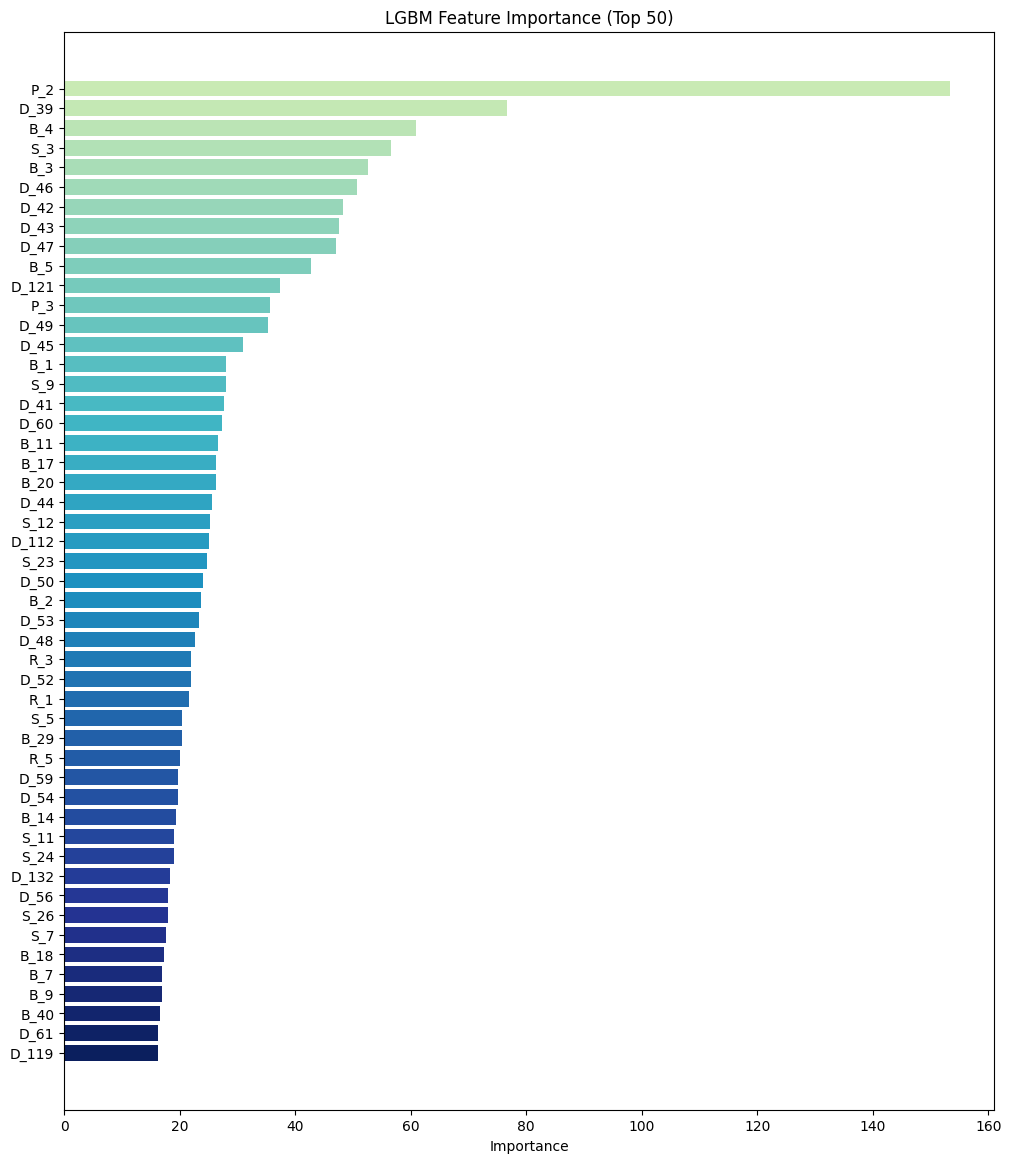

In [22]:
plt.figure(figsize=(12, 14))
pal = sns.color_palette("YlGnBu", 65).as_hex()

plt.barh(ft_importance.index, ft_importance.values, color=pal[::-1])
plt.xlabel('Importance')
plt.title('LGBM Feature Importance (Top 50)')


### Competition Metric Evaluation

In [13]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

y_valid, M=[],[]

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all_features, y)):
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    lgbm_ordinal.fit(X_train, y_train)
    y_pred = lgbm_ordinal.predict_proba(X_val)[:,1]

    y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score=amex_metric(y_true = y_true, y_pred = y_pred)
    
    M.append(M_score)
    y_valid.append(y_val)

np.mean(M)

0.7815170095305302

### Insights: 

- Similar to the HistGradientBoostClassifierm test score is highest when I include all the features in the model.

- Again the balanced_accuracy is very close for model including all features and model including only the numerical features.

- From the LGBM feature importance, Payment 2 (P_2) has the highest average importance. It is interseting that P_2 also is the most correlated with the target variable.

- I got a value of 0.87 for the competition metric for the LGBM classifier.

### 5.3 XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of the gradient boosting algorithm, which is widely used for supervised learning tasks. It is popular for its speed, performance, and ability to handle complex structured data. XGBoost is based on the gradient boosting framework, which builds an ensemble of weak learners (typically decision trees) to create a strong predictive model. XGBoost is designed to optimize performance and computational speed. It has become a standard algorithm for winning machine learning competitions and is widely used in various industry applications.

XGBoost can handle missing values internally during the training process. This is important, because we have many missing values in our dataset. XGBoost supports built-in cross-validation, enabling users to estimate the performance of the model and tune hyperparameters effectively.

### Hyperparameter Tuning

I will use RandomizedSearchCV to find the optimum hyperparameters for my model.

In hyperparameter tuning, RandomizedSearchCV is an alternative to GridSearchCV, which performs an exhaustive search over a specified grid of hyperparameters. Unlike GridSearchCV, which tries every possible combination of hyperparameters, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified distributions. This approach is useful when the search space of hyperparameters is large and it is computationally expensive to explore every single combination.

The RandomizedSearchCV class performs cross-validated search over the hyperparameter space by selecting random combinations of hyperparameters for evaluation. It works by fitting the model on different hyperparameter settings and evaluating their performance using cross-validation. It then selects the best combination of hyperparameters based on the specified scoring metric. The scoring I will use for cross_validating is balanced_accuracy.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist',enable_categorical= True)

param_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}
mse_random = RandomizedSearchCV(model, param_distributions = param_random_gb, n_iter = 10, scoring = 'balanced_accuracy', cv = 4, verbose = 1)
mse_random.fit(X_train, y_train)

print("Best parameter: ", mse_random.best_params_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameter:  {'subsample': 0.7000000000000002, 'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.15000000000000002}

### ROC Curve and AUC Metric

[0]	validation_0-auc:0.93366	validation_1-auc:0.93159
[1]	validation_0-auc:0.93861	validation_1-auc:0.93647
[2]	validation_0-auc:0.94112	validation_1-auc:0.93915
[3]	validation_0-auc:0.94338	validation_1-auc:0.94161
[4]	validation_0-auc:0.94460	validation_1-auc:0.94300
[5]	validation_0-auc:0.94539	validation_1-auc:0.94383
[6]	validation_0-auc:0.94615	validation_1-auc:0.94457
[7]	validation_0-auc:0.94680	validation_1-auc:0.94523
[8]	validation_0-auc:0.94726	validation_1-auc:0.94562
[9]	validation_0-auc:0.94792	validation_1-auc:0.94633
[10]	validation_0-auc:0.94857	validation_1-auc:0.94688
[11]	validation_0-auc:0.94907	validation_1-auc:0.94736
[12]	validation_0-auc:0.94979	validation_1-auc:0.94804
[13]	validation_0-auc:0.95040	validation_1-auc:0.94857
[14]	validation_0-auc:0.95087	validation_1-auc:0.94902
[15]	validation_0-auc:0.95142	validation_1-auc:0.94949
[16]	validation_0-auc:0.95178	validation_1-auc:0.94985
[17]	validation_0-auc:0.95211	validation_1-auc:0.95012
[18]	validation_0-au

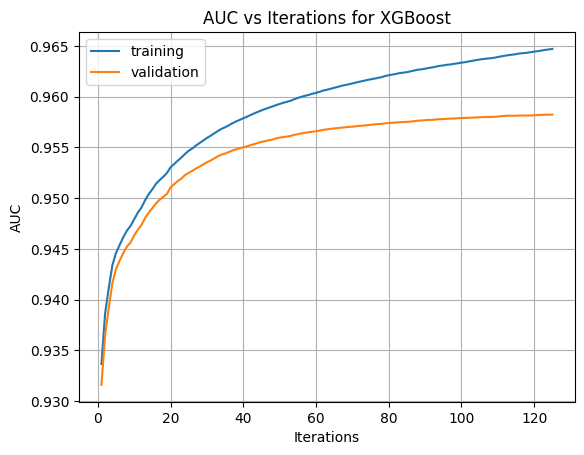

In [7]:
xgb_params = {'objective':'binary:logistic','max_depth': 5,'learning_rate': 0.15,'n_estimators':125,'enable_categorical': True,'tree_method':'gpu_hist', 'eval_metric': 'auc', 'early_stopping_rounds' : 10, 'subsample': 0.7}                 
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

train_history = xgb_model.evals_result()
iterations = len(train_history["validation_0"]["auc"])

y_pred = xgb_model.predict_proba(X_val)[:,1]

y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
y_true = y_val.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

M_score=amex_metric(y_true = y_true, y_pred = y_pred)    
print(f"M_score: {M_score}")
    
plt.plot(range(1,iterations+1), train_history["validation_0"]["auc"], label="training")
plt.plot(range(1,iterations+1), train_history["validation_1"]["auc"], label="validation")
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.title('AUC vs Iterations for XGBoost')
plt.show()

### Feature Selection and Cross Validation

In [14]:
params = {'objective':'binary:logistic','max_depth': 4,'learning_rate': 0.15,'n_estimators':125, 'subsample':0.7, 'enable_categorical': True,'tree_method':'gpu_hist'}                 
model = xgb.XGBClassifier(**params)
n_cv_folds = 3
scoring = 'balanced_accuracy'
xgb_ordinal = make_pipeline(ordinal_encoder, model)

XGB_top_ten_features = cross_validate(model, X[sorted_targ[:10].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
XGB_top_thirty_features = cross_validate(model, X[sorted_targ[:30].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
XGB_top_fifty_features = cross_validate(model, X[sorted_targ[:50].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
XGB_top_hundred_features = cross_validate(model, X[sorted_targ[:100].index.tolist()], y, cv=n_cv_folds, scoring=scoring)
XGB_numerical_features_only = cross_validate(model, X, y, cv=n_cv_folds, scoring=scoring)
XGB_with_categoricals = cross_validate(xgb_ordinal, X_all_features, y, cv=n_cv_folds, scoring=scoring)

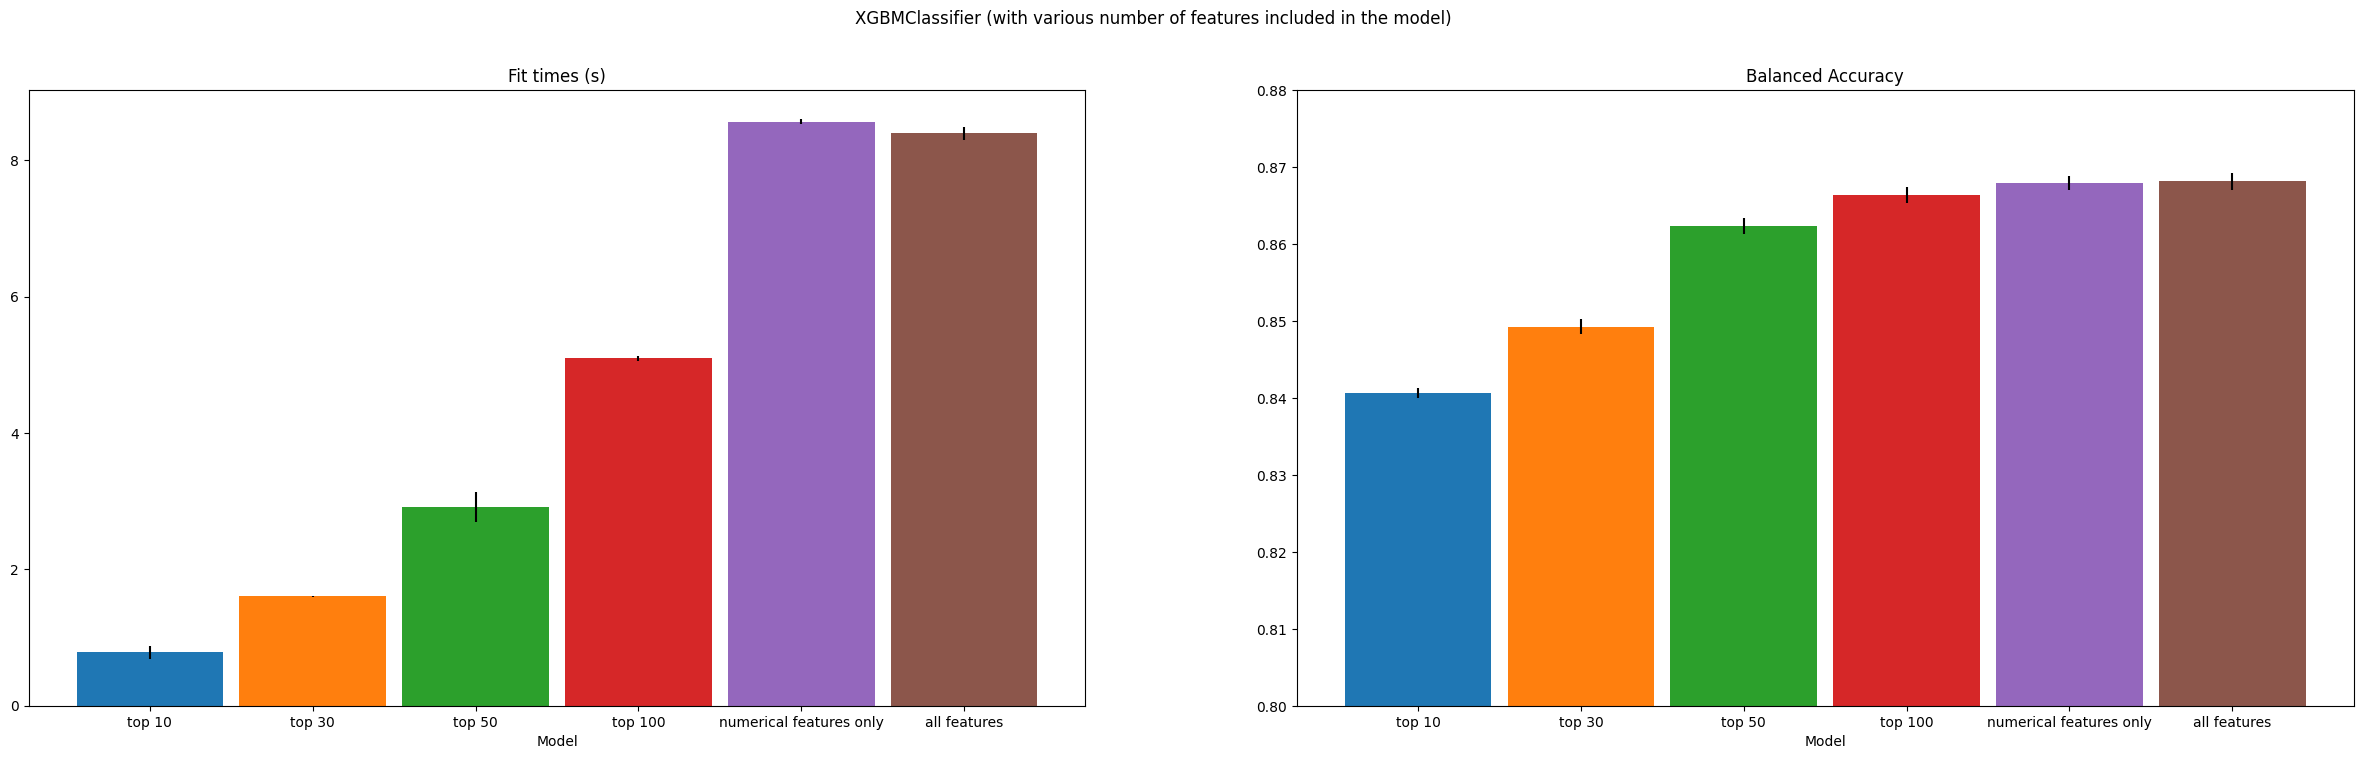

In [19]:
plot_results("XGBMClassifier (with various number of features included in the model)", [0.8, 0.88], [XGB_top_ten_features, XGB_top_thirty_features, XGB_top_fifty_features, XGB_top_hundred_features, XGB_numerical_features_only, XGB_with_categoricals], ['top 10', 'top 30', 'top 50', 'top 100','numerical features only', 'all features'])

In [16]:
print(f"XGBClassifier (trained with numerical features) mean test score: {np.mean(XGB_numerical_features_only['test_score'])}")
print(f"XGBClassifier (trained with all features) mean test score: {np.mean(XGB_with_categoricals['test_score'])}\n")

print(f"XGBClassifier (trained with numerical features) std of test scores: {np.std(XGB_numerical_features_only['test_score'])}")
print(f"XGBClassifier (trained with all features) std of test scores: {np.std(XGB_with_categoricals['test_score'])}")

XGBClassifier (trained with numerical features) mean test score: 0.8678617386682808
XGBClassifier (trained with all features) mean test score: 0.8680823666557776

XGBClassifier (trained with numerical features) std of test scores: 0.0008849855205685962
XGBClassifier (trained with all features) std of test scores: 0.0010974326814780291


The test scores are the highest when including all features.

### Competition Metric Evalutaion

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

y_valid, M=[],[]

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all_features, y)):
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    xgb_ordinal.fit(X_train, y_train)
    y_pred = xgb_ordinal.predict_proba(X_val)[:,1]

    y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score=amex_metric(y_true = y_true, y_pred = y_pred)
    
    M.append(M_score)
    y_valid.append(y_val)

np.mean(M)

0.779272513725188

### Insights: 

- Similar to the previous models, balanced_accuracy is the highest when I include all the features in the model.

- balanced_accuracy is very close for the model including all features and mthe odel including only the numerical features.

- I get avalue of 0.78 for the competition metric.

### 6. Comparison of the three Models

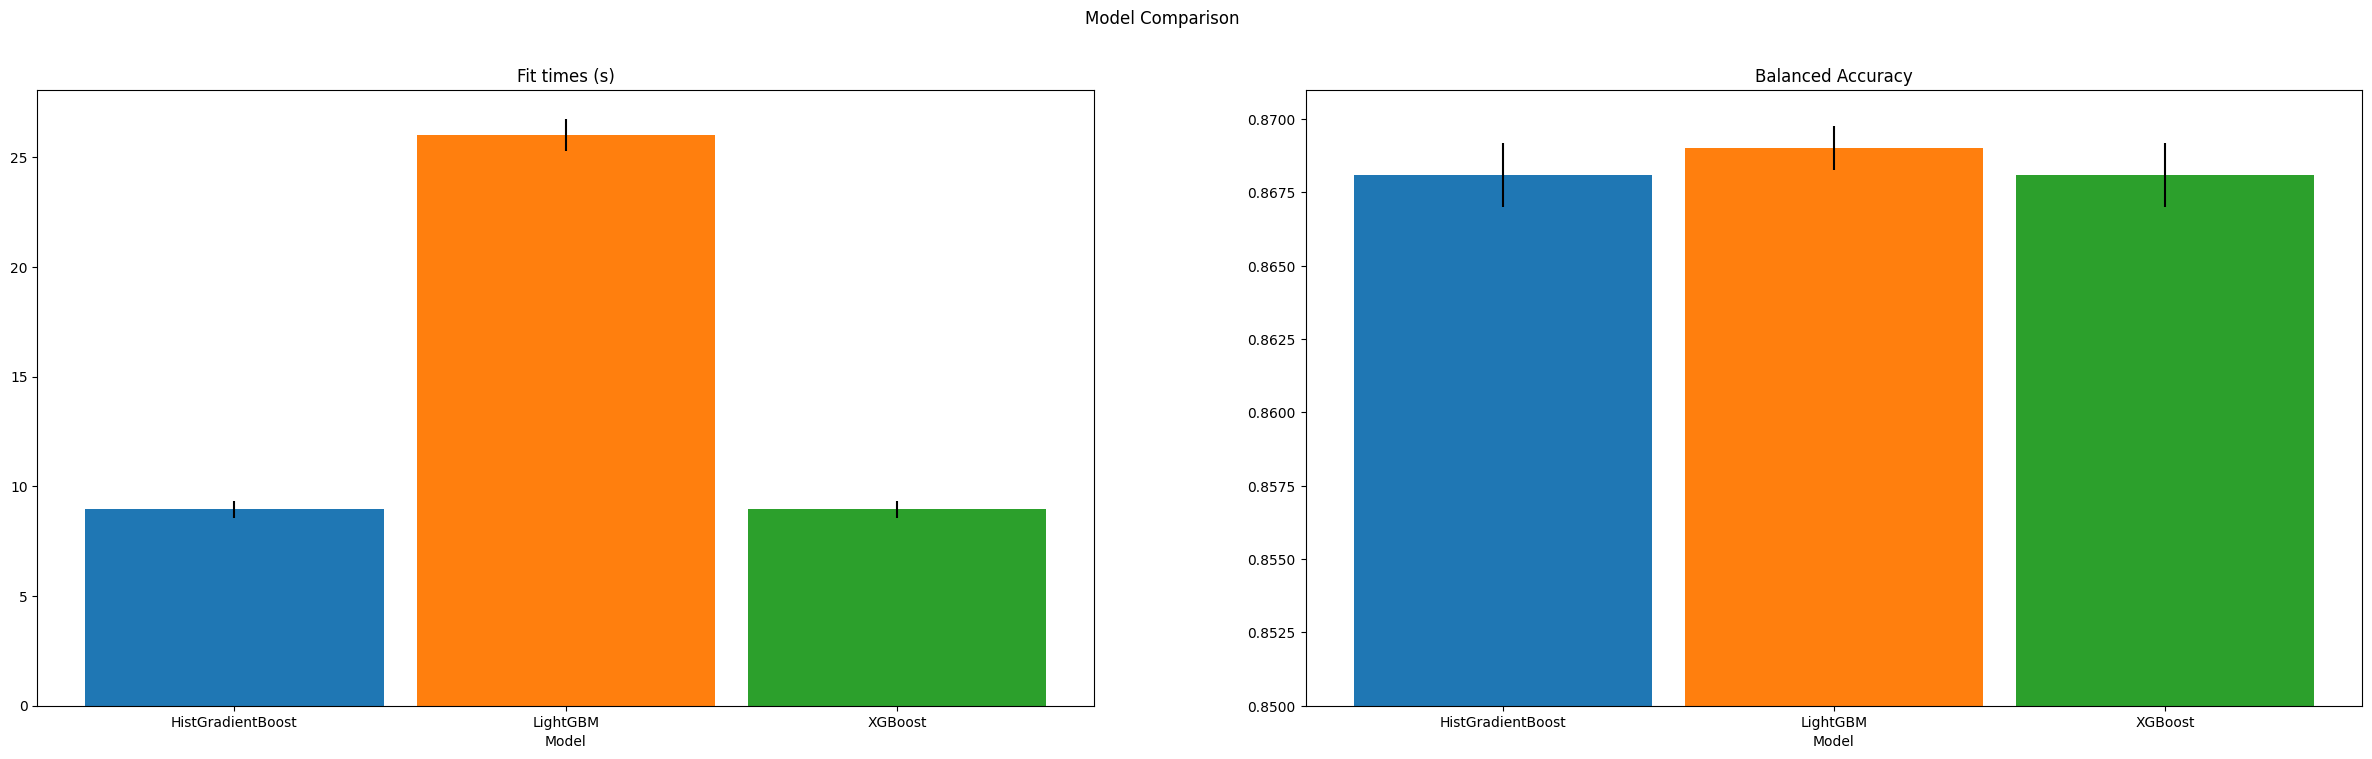

In [21]:
plot_results("Model Comparison", [0.85, 0.871], [XGB_with_categoricals, LGB_with_categoricals, XGB_with_categoricals], ['HistGradientBoost', 'LightGBM', 'XGBoost'])

### Insights:

- LightGBM with all numerical and categocial features included has the highest balanced accuracy. It is interesting that it also has the highest fit time.

### 6. Submission

Since HistGradientBoostClassifier with all features seems to be the most promising model, I will use it to make predictions on the test data.

In [13]:
del train_data, X

model = lgbm_ordinal
model.fit(X_all_features, y)

del X_all_features, y

In [14]:
test_data = pd.read_feather('../input/amexfeather/test_data.ftr')
test_data = test_data.groupby('customer_ID').tail(1).set_index('customer_ID')
gc.collect()

6383

In [15]:
y_pred = model.predict_proba(test_data.iloc[:,1:])[:,1]

In [16]:
sub = pd.DataFrame({'customer_ID': test_data.index, 'prediction': y_pred})
sub.to_csv('submission.csv', index=False)
display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.034901
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.002048
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.060729
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.337726
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.864829
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.019784
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.739082
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.652729
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.414953
